In [1]:
import sys
# import dataiku
import numpy as np
import pandas as pd
import sklearn as sk
from pyhive import hive

from collections import defaultdict, Counter

In [2]:
import plotly.offline as ply
import plotly.graph_objs as go

ply.init_notebook_mode(connected=True)

In [3]:
!kinit -kt EDTolstov.keytab EDTolstov
!klist

Ticket cache: FILE:/tmp/krb5cc_815720870
Default principal: EDTolstov@BEE.VIMPELCOM.RU

Valid starting       Expires              Service principal
10/09/2019 18:23:33  10/10/2019 04:23:33  krbtgt/BEE.VIMPELCOM.RU@BEE.VIMPELCOM.RU
	renew until 10/16/2019 18:23:33


In [4]:
conn = hive.Connection(host = "hd-has014.vimpelcom.ru", port = "10000", username = "edtolstov", database = "arstel", 
                       auth = "KERBEROS", kerberos_service_name = "hive", configuration = {'job.queue.name': 'adhoc'})
cursor = conn.cursor()

s00='''set mapred.job.queue.name=adhoc'''
cursor.execute(s00)

## Intro

Задача состоит в кластеризации абонентов-мультисимеров. В задаче был использован стандартный алгоритм кластеризации K-Means. План построения модели состоит в преобразовании данных под метрический алгоритм, анализа количества кластеров с помощью метода "локтя", анализ получившихся кластеров в разрезе ключевых показателей клиента.

### Data load

In [12]:
%%time

s1 = '''select * from cvm_stg.khn_multisim_similar_dataset'''

s1 = s1.replace('\n',' ')

data = pd.read_sql(s1, conn)

CPU times: user 1min 6s, sys: 735 ms, total: 1min 7s
Wall time: 1min 55s


In [13]:
def df_to_columns(df):
    a = []
    a = df.columns.tolist()[0].split(".")
    len(a)
    if len(a) <=1:
        print("Already formatted")
    else:
        cols = []
        for i in df.columns.tolist():
            cols.append(i.split(".")[1])
        df.columns = cols

In [14]:
df_to_columns(data)

In [15]:
data.head()

subs_key multisim_or_not beeline_or_not claim reason_of_second_sim  \
0           0            None           None  None                 None   
1  9002345685               1        unknown     0              unknown   
2  9014404192               1              1     0         for internet   
3  9015244126            None           None  None                 None   
4  9015350236            None           None  None                 None   

  goal_for_second_sim sum_for_second_sim      ban_key market_key  \
0                None               None          NaN       None   
1             unknown            unknown  638008453.0        KRD   
2             unknown            500-599  586875531.0        UFA   
3                None               None  609005067.0        VIP   
4                None               None          NaN       None   

   passport_corrected_ind      ...       debt_ind days_in_block_avg_m3  \
0                     NaN      ...            NaN                  NaN   
1                     1.0      ...            0.0                  0.0   
2                     1.0      ...            0.0                  0.0   
3                     1.0      ...            0.0                  0.0   
4                     NaN      ...            NaN                  NaN   

  network_lifetime   arpu1 dual_sim market_wage_group age_category  \
0              NaN     NaN     None              None          NaN   
1            756.0   15.90  DualSim              High          4.0   
2           1054.0  154.77  DualSim              High          5.0   
3            850.0   18.30  DualSim        Extra High          6.0   
4              NaN     NaN     None              None          NaN   

  gender_male_prob camp_id     camp_code  
0              NaN    None          None  
1         0.492961    None  R159-STH1226  
2         0.934326    None     R163-C273  
3         0.472277    None          None  
4              NaN    None          None  

[5 rows x 49 columns]

In [8]:
data_orig = data.copy()

### Preparing data and clustering

Разобьем отдельно признаки на категориальные и числовые

In [17]:
cat_feats = ['beeline_or_not','claim','reason_of_second_sim','goal_for_second_sim','sum_for_second_sim','market_key','device_os_agg','device_data_class','pp_archetype','pp_archetype_agg','pp_group','dual_sim']
num_feats=['passport_corrected_ind','lte_ind','arpu_gprs_share','arpu_sms_share','arpu_roaming_share','arpu_voice_share','count_voice1','voice1_international_share','voice1_gor_share','voice1_intercity_share','voice1_offnet_share','voice1_out_share','avg_call_voice1_out','count_week_roam','count_sms1','count_gprs1','count_voice1_international','count_voice1_gor','count_voice1_intercity','count_voice1_offnet','count_voice1_out','service_margin','debt_ind','days_in_block_avg_m3','network_lifetime','arpu1']

In [18]:
#null dealing

data_fltrd = data[data['multisim_or_not'].notnull()]
data_fltrd = data_fltrd[data_fltrd['market_key'].notnull()]
data_fltrd = data_fltrd[data_fltrd['multisim_or_not']!='unknown']

In [19]:
# filter to multisim
data_fltrd = data_fltrd[data_fltrd['multisim_or_not']=='1']

In [20]:
data_fltrd.shape

(209965, 49)

In [21]:
data_c = data_fltrd[cat_feats]



data_c['device_data_class'] = data_c['device_data_class'].fillna('Unknown', inplace=False)
data_c['dual_sim'] = data_c['dual_sim'].fillna('Unknown', inplace=False)

data_c.info()

/opt/anaconda3/envs/py_36_catboost_0.11.1/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/opt/anaconda3/envs/py_36_catboost_0.11.1/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



<class 'pandas.core.frame.DataFrame'>
Int64Index: 209965 entries, 1 to 402649
Data columns (total 12 columns):
beeline_or_not          209965 non-null object
claim                   209965 non-null object
reason_of_second_sim    209965 non-null object
goal_for_second_sim     209965 non-null object
sum_for_second_sim      209965 non-null object
market_key              209965 non-null object
device_os_agg           209965 non-null object
device_data_class       209965 non-null object
pp_archetype            209965 non-null object
pp_archetype_agg        209965 non-null object
pp_group                209965 non-null object
dual_sim                209965 non-null object
dtypes: object(12)
memory usage: 20.8+ MB


In [22]:
LIMIT_DUMMIES = 100
# cat_feats
dummy_values = {}

def select_dummy_values(train, features):
    dummy_values = {}
    for feature in cat_feats:
        values = [
            value
            for (value, _) in Counter(data_c[feature]).most_common(LIMIT_DUMMIES)
        ]
        dummy_values[feature] = values
    return dummy_values

DUMMY_VALUES = select_dummy_values(data_c, cat_feats)

In [70]:
data_c.head()

beeline_or_not claim reason_of_second_sim goal_for_second_sim sum_for_second_sim market_key device_os_agg device_data_class      pp_archetype pp_archetype_agg    pp_group dual_sim
1         unknown     0              unknown             unknown            unknown        KRD   ANDROID_IOS                SS          B2C flat             Flat  PP_SEKUNDA  DualSim
2               1     0         for internet             unknown            500-599        UFA   ANDROID_IOS                AS           B2C VAS             Flat       PP_GO  DualSim
6               0     0              unknown             unknown            unknown        KMR   ANDROID_IOS                MS          B2C flat             Flat  PP_SEKUNDA  DualSim
12              1     0              unknown             unknown            100-199        VLA   ANDROID_IOS                AS         B2C onnet             Flat  PP_NODOUBT  DualSim
20              1     0              unknown             unknown            100-199        PNZ   PROPRIETARY                BP  B2C Bundle Unlim           Bundle   PP_UNLIM2  DualSim

In [23]:
def dummy_encode_dataframe(df):
    for (feature, dummy_values) in DUMMY_VALUES.items():
        for dummy_value in dummy_values:
            dummy_name = u'%s_value_%s' % (feature, dummy_value)
            df[dummy_name] = (df[feature] == dummy_value).astype(float)
        del df[feature]
        print ('Dummy-encoded feature %s' % feature)

dummy_encode_dataframe(data_c)

/opt/anaconda3/envs/py_36_catboost_0.11.1/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Dummy-encoded feature beeline_or_not
Dummy-encoded feature claim
Dummy-encoded feature reason_of_second_sim
Dummy-encoded feature goal_for_second_sim
Dummy-encoded feature sum_for_second_sim
Dummy-encoded feature market_key
Dummy-encoded feature device_os_agg
Dummy-encoded feature device_data_class
Dummy-encoded feature pp_archetype
Dummy-encoded feature pp_archetype_agg
Dummy-encoded feature pp_group
Dummy-encoded feature dual_sim


In [5]:
# data_orig[num_feats].head()

In [24]:
data_num = data_fltrd[num_feats]

In [25]:
impute_when_missing = [{'impute_with': u'MEAN', 'feature': 'passport_corrected_ind'},{'impute_with': u'MEAN', 'feature': 'lte_ind'},{'impute_with': u'MEAN', 'feature': 'arpu_gprs_share'},{'impute_with': u'MEAN', 'feature': 'arpu_sms_share'},{'impute_with': u'MEAN', 'feature': 'arpu_roaming_share'},{'impute_with': u'MEAN', 'feature': 'arpu_voice_share'},{'impute_with': u'MEAN', 'feature': 'count_voice1'},{'impute_with': u'MEAN', 'feature': 'voice1_international_share'},{'impute_with': u'MEAN', 'feature': 'voice1_gor_share'},{'impute_with': u'MEAN', 'feature': 'voice1_intercity_share'},{'impute_with': u'MEAN', 'feature': 'voice1_offnet_share'},{'impute_with': u'MEAN', 'feature': 'voice1_out_share'},{'impute_with': u'MEAN', 'feature': 'avg_call_voice1_out'},{'impute_with': u'MEAN', 'feature': 'count_week_roam'},{'impute_with': u'MEAN', 'feature': 'count_sms1'},{'impute_with': u'MEAN', 'feature': 'count_gprs1'},{'impute_with': u'MEAN', 'feature': 'count_voice1_international'},{'impute_with': u'MEAN', 'feature': 'count_voice1_gor'},{'impute_with': u'MEAN', 'feature': 'count_voice1_intercity'},{'impute_with': u'MEAN', 'feature': 'count_voice1_offnet'},{'impute_with': u'MEAN', 'feature': 'count_voice1_out'},{'impute_with': u'MEAN', 'feature': 'service_margin'},{'impute_with': u'MEAN', 'feature': 'debt_ind'},{'impute_with': u'MEAN', 'feature': 'days_in_block_avg_m3'},{'impute_with': u'MEAN', 'feature': 'network_lifetime'},{'impute_with': u'MEAN', 'feature': 'arpu1'}]

# Features for which we impute missing values"
for feature in impute_when_missing:
    if feature['impute_with'] == 'MEAN':
        v = data_num[feature['feature']].mean()
        
    data_num[feature['feature']] = data_num[feature['feature']].fillna(v)
    
    print ('Imputed missing values in feature %s with value %s' % (feature['feature'], v))

Imputed missing values in feature passport_corrected_ind with value 0.9498106827328364


/opt/anaconda3/envs/py_36_catboost_0.11.1/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Imputed missing values in feature lte_ind with value 0.3655656895196818
Imputed missing values in feature arpu_gprs_share with value 0.24739709475605706
Imputed missing values in feature arpu_sms_share with value 0.03180071422819064
Imputed missing values in feature arpu_roaming_share with value 0.013171142189059848
Imputed missing values in feature arpu_voice_share with value 0.5499347528394453
Imputed missing values in feature count_voice1 with value 203.08068779311165
Imputed missing values in feature voice1_international_share with value 8.40249637029488e-05
Imputed missing values in feature voice1_gor_share with value 0.0497228555355301
Imputed missing values in feature voice1_intercity_share with value 0.165214668522159
Imputed missing values in feature voice1_offnet_share with value 0.40419748517057963
Imputed missing values in feature voice1_out_share with value 0.372518086439848
Imputed missing values in feature avg_call_voice1_out with value 1.8853269073198633
Imputed missing

In [4]:
# data_num.describe()

In [27]:
rescale_features = {'passport_corrected_ind':'AVGSTD','lte_ind':'AVGSTD','arpu_gprs_share':'AVGSTD','arpu_sms_share':'AVGSTD','arpu_roaming_share':'AVGSTD','arpu_voice_share':'AVGSTD','count_voice1':'AVGSTD','voice1_international_share':'AVGSTD','voice1_gor_share':'AVGSTD','voice1_intercity_share':'AVGSTD','voice1_offnet_share':'AVGSTD','voice1_out_share':'AVGSTD','avg_call_voice1_out':'AVGSTD','count_week_roam':'AVGSTD','count_sms1':'AVGSTD','count_gprs1':'AVGSTD','count_voice1_international':'AVGSTD','count_voice1_gor':'AVGSTD','count_voice1_intercity':'AVGSTD','count_voice1_offnet':'AVGSTD','count_voice1_out':'AVGSTD','service_margin':'AVGSTD','debt_ind':'AVGSTD','days_in_block_avg_m3':'AVGSTD','network_lifetime':'AVGSTD','arpu1':'AVGSTD'}

for (feature_name, rescale_method) in rescale_features.items():
    if rescale_method == 'AVGSTD':
        shift = data_num[feature_name].mean()
        scale = data_num[feature_name].std()
    if scale == 0.:
        del data_num[feature_name]
        print ('Feature %s was dropped because it has no variance' % feature_name)
    else:
        print ('Rescaled %s' % feature_name)
        data_num[feature_name] = (data_num[feature_name] - shift).astype(np.float64) / scale

Rescaled passport_corrected_ind
Rescaled lte_ind
Rescaled arpu_gprs_share


/opt/anaconda3/envs/py_36_catboost_0.11.1/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Rescaled arpu_sms_share
Rescaled arpu_roaming_share
Rescaled arpu_voice_share
Rescaled count_voice1
Rescaled voice1_international_share
Rescaled voice1_gor_share
Rescaled voice1_intercity_share
Rescaled voice1_offnet_share
Rescaled voice1_out_share
Rescaled avg_call_voice1_out
Rescaled count_week_roam
Rescaled count_sms1
Rescaled count_gprs1
Rescaled count_voice1_international
Rescaled count_voice1_gor
Rescaled count_voice1_intercity
Rescaled count_voice1_offnet
Rescaled count_voice1_out
Rescaled service_margin
Rescaled debt_ind
Rescaled days_in_block_avg_m3
Rescaled network_lifetime
Rescaled arpu1


In [28]:
# соединяем преобразованные категориальные и числовые признаки в итоговый датасет

df = pd.concat([data_c, data_num.reindex(data_c.index)], axis=1)

Данные готовы для кластеризации

### Clustering

In [30]:
# начнем с 10 кластеров

from sklearn.cluster import KMeans
clustering_model = KMeans(n_clusters=10)

In [83]:
%%time 
clusters = clustering_model.fit_predict(df)

CPU times: user 2min 8s, sys: 42.4 s, total: 2min 50s
Wall time: 1min 59s


In [87]:
clusters

array([4, 2, 1, ..., 3, 1, 0], dtype=int32)

In [85]:
from sklearn.metrics import silhouette_score
silhouette = silhouette_score(df.values, clusters, metric='euclidean', sample_size=10000)
print ("Silhouette score :", silhouette)

Silhouette score : 0.0699983994836


In [86]:
from tqdm import tqdm_notebook
n_classes = len(set(clusters))

inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(df)
    inertia.append(np.sqrt(kmeans.inertia_))
    #

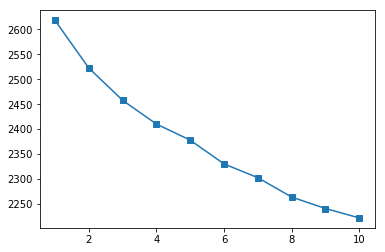

In [89]:
import matplotlib.pyplot as plt
plt.plot(range(1,11), inertia, marker='s');

In [90]:
pd.DataFrame(clusters)[0].value_counts()

4    72285
3    50132
2    29938
1    28969
0    10659
9     9887
6     4217
8     3871
5        6
7        1
Name: 0, dtype: int64

По данным только мультисимеров, кластеры плохо делятся, не видно "локтя" + есть очень маленькие кластеры.

Если убрать условие на мультисим=1 и посмотреть локтевой метод на той же выборке, то видим что оптимально выбрать 3 кластера. Данного упражнения в ноутбуке нет, чтобы не загромодждать. Также при анализе данных видим, что оптимальное количество кластеров составляет 3

In [40]:
# оставим 3 кластера

In [38]:
%%time 
clustering_model = KMeans(n_clusters=3)
clusters = clustering_model.fit_predict(df)

CPU times: user 1min 10s, sys: 40.1 s, total: 1min 50s
Wall time: 1min 8s


In [41]:
df_clusters = pd.DataFrame(clusters).rename(columns={0: "clusters"})
df_subs = data_fltrd.reset_index()

In [42]:
print(df_subs.shape)
print(df_clusters.shape)

(209965, 50)
(209965, 1)


In [43]:
pd.DataFrame(clusters)[0].value_counts()

2    121666
1     53557
0     34742
Name: 0, dtype: int64

In [44]:
# Соединим кластеры 

df_sub_clust = pd.concat([df_subs, df_clusters.reindex(df_subs.index)], axis=1)

In [3]:
# df_sub_clust.head()

In [36]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

__Итого:__ Имеем датасет мультисимеров, размечанных по 3 кластерам

### Analysis of clusters

По получившимся кластерам смотрим статистики и графики по ключевым показателям. 
Введем обозначения кластеров:
- 0 - дешевые 
- 1 - бандл
- 2 - флэт

Список показателей.

In [46]:
df = df_sub_clust

In [49]:
# Численность кластеров

cnt = df['clusters'].value_counts().sort_index()
print(cnt)

0     34742
1     53557
2    121666
Name: clusters, dtype: int64


In [51]:
print(cnt[0]/sum(cnt))
print(cnt[1]/sum(cnt))
print(cnt[2]/sum(cnt))
# print(cnt[3]/sum(cnt))

0.16546567285
0.255075845974
0.579458481175


### Network lifetime

In [52]:
df.groupby('clusters', as_index=False).agg({"network_lifetime": "mean"})

clusters  network_lifetime
0         0       2459.297220
1         1       2109.138731
2         2       3327.614798

In [53]:
df.groupby('clusters', as_index=False).agg({"network_lifetime": "median"})

clusters  network_lifetime
0         0            2038.0
1         1            1460.0
2         2            3504.0

In [58]:
# Silno otlichaetsya cluster N=2

In [54]:
df['network_lifetime'].describe()

count    209965.000000
mean       2873.134232
std        1704.226605
min           4.000000
25%        1304.000000
50%        2706.000000
75%        4515.000000
max        6978.000000
Name: network_lifetime, dtype: float64

data_plot = [    
    
    go.Histogram(
        x=df[df['clusters']==0]['network_lifetime'],
        name='Cluster 0. Low-end',
        nbinsx=200
    ),
    
    go.Histogram(
        x=df[df['clusters']==1]['network_lifetime'],
        name='Cluster 1. Bundle',
        nbinsx=200
    ),
    
    go.Histogram(
        x=df[df['clusters']==2]['network_lifetime'],
        name='Cluster 2. Flat-low',
        nbinsx=200
    ),
    
    
]

layout = go.Layout(
    title='Lifetime'
)

fig = go.Figure(data=data_plot, layout=layout)

ply.iplot(fig)

__Вывод:__

- Low-end. Равномерно распределен
- Bundle. Меньший lifetime
- Flat-low. Больший lifetime


### ARPU

In [56]:
df.groupby('clusters', as_index=False).agg({"arpu1": "mean"})

clusters       arpu1
0         0   93.432886
1         1  482.613969
2         2  148.014000

In [57]:
df.groupby('clusters', as_index=False).agg({"arpu1": "median"})

clusters    arpu1
0         0   12.240
1         1  421.085
2         2   99.380

data_plot = [    
    
    go.Histogram(
        x=df[df['clusters']==0]['arpu1'].where(lambda x: (x >= 0) & (x < 500)),
        name='Cluster 0',
        nbinsx=200
    ),
    
    go.Histogram(
        x=df[df['clusters']==1]['arpu1'].where(lambda x: (x >= 0) & (x < 500)),
         name='Cluster 1',
        nbinsx=200
    ),
    
    go.Histogram(
        x=df[df['clusters']==2]['arpu1'].where(lambda x: (x >= 0) & (x < 500)),
         name='Cluster 2',
        nbinsx=200
    ),
    
]

layout = go.Layout(
    title='Arpu',
    yaxis=dict(range=[0, 8000])    
)

fig = go.Figure(data=data_plot, layout=layout)

ply.iplot(fig)

__Вывод:__

- Low-end. Низкий арпу. Большое распределение в нуле
- Bundle. Арпу больше, распределение в районе 350-500
- Flat-low. Низкий арпу, много записей в нуле и в районе 100 рублей


### Arhtype

In [2]:
# gr0 = df[(df['pp_archetype_agg']=='Bundle')&(df['clusters'].isin([0,1,2]))]\
# .groupby(df['clusters'].fillna('_NA')).agg({'clusters': np.size}) \
# .rename({'clusters': 'cnt'}, axis=1)

# gr1 = df[(df['pp_archetype_agg']=='Flat')&(df['clusters'].isin([0,1,2]))]\
# .groupby(df['clusters'].fillna('_NA')).agg({'clusters': np.size}) \
# .rename({'clusters': 'cnt'}, axis=1)

# data_plot = [    
    
#     go.Bar(
#         x=gr0.index,
#         y=gr0['cnt'],
#         name ='Bundle'
#     ),    
    
#     go.Bar(
#         x=gr1.index,
#         y=gr1['cnt'],
#         name = 'Flat'
#     ),  
    
# ]

# layout = go.Layout(
#     title='Archetype'
# )

# fig = go.Figure(data=data_plot, layout=layout)

# ply.iplot(fig)

__Вывод:__

- Low-end. 72% bundle 
- Bundle. 92% bundle
- Flat-low. 30% bundle


In [62]:
a = df.groupby(['clusters', 'pp_archetype_agg'])['pp_archetype_agg'].count()
# print(a)

In [63]:
print(a[0][0]/(a[0][0]+a[0][1]))
print(a[1][0]/(a[1][0]+a[1][1]))
print(a[2][0]/(a[2][0]+a[2][1]))


0.720735544586
0.92896791796
0.290484098852


### GPRS share + Count gprs

In [65]:
df.groupby('clusters', as_index=False).agg({"arpu_gprs_share": "mean"})

clusters  arpu_gprs_share
0         0          0.50425
1         1          0.37707
2         2          0.14441

In [66]:
df.groupby('clusters', as_index=False).agg({"arpu_gprs_share": "median"})

clusters  arpu_gprs_share
0         0             0.27
1         1             0.42
2         2             0.00

In [68]:
df['count_gprs1'] = df['count_gprs1']/1000000

In [70]:
df.groupby('clusters', as_index=False).agg({"count_gprs1": "mean"})

clusters  count_gprs1
0         0   220.822917
1         1  3653.219109
2         2   201.972876

In [71]:
df.groupby('clusters', as_index=False).agg({"count_gprs1": "median"})

clusters  count_gprs1
0         0     0.000000
1         1   675.344384
2         2     0.000000

__Вывод:__

- Low-end. Низкое доля инета в арпу + низкое его потребление
- Bundle. Доля в арпу - около 40-50%
- Flat-low. Самое низкие доля и потребление, большое смещение в ноль

### Voice share

In [72]:
df.groupby('clusters', as_index=False).agg({"arpu_voice_share": "mean"})

clusters  arpu_voice_share
0         0          0.676964
1         1          0.455038
2         2          0.573483

In [73]:
df.groupby('clusters', as_index=False).agg({"arpu_voice_share": "median"})

clusters  arpu_voice_share
0         0              0.36
1         1              0.42
2         2              0.53

__Вывод:__

- Low-end. Много в нуле + распределение около 20-60%
- Bundle. Похоже на нормальное распределение с медианой 40% потребления
- Flat-low. Есть большая часть распределения в 100% отметка

__Roaming and sms__

In [75]:
df.groupby('clusters', as_index=False).agg({"arpu_roaming_share": "mean"})

clusters  arpu_roaming_share
0         0            0.006881
1         1            0.010726
2         2            0.015764

Чуть бОльшая доля у тратящих 1,2

In [77]:
df.groupby('clusters', as_index=False).agg({"arpu_sms_share": "mean"})

clusters  arpu_sms_share
0         0        0.009790
1         1        0.012926
2         2        0.044262

Чуть бОльшая доля у кластера флэт

### Device

In [79]:
df['device_os_agg'].value_counts()

ANDROID_IOS    140066
PROPRIETARY     60957
Other            8942
Name: device_os_agg, dtype: int64

In [137]:
# df.groupby(['clusters', 'device_data_class'])['device_data_class'].count()

---------------

1. AS - advanced smartphone
2. BP - basic phone
3. MS - medium smart
4. FP - feature phone
5. SS - Simple smart
5. ND - no data?

In [81]:
df['device_data_class'].value_counts()

AS     102021
BP      56672
MS      36408
FP       4202
SS       2775
ND       2756
TAB      1128
USB         5
Name: device_data_class, dtype: int64

In [ ]:
# df_reason = pd.DataFrame({'cnt' : df.groupby( [ "clusters", "reason_of_second_sim"] ).size()}).reset_index()
# df_reason = df_reason[df_reason['reason_of_second_sim']!='unknown']
# df_reason['sum1'] = df_reason.groupby('clusters').cnt.transform(np.sum)

# df_reason['share'] = df_reason['cnt']/df_reason['sum1']

In [85]:
# табличное представление разбивки по дата классам

a  = pd.DataFrame({'cnt' : df.groupby(["clusters","device_data_class"]).size()}).reset_index()
a['sum1'] = a.groupby('clusters').cnt.transform(np.sum)

a['share'] = a['cnt']/a['sum1']

In [86]:
a[(a['share']>0.1)]

clusters device_data_class    cnt    sum1     share
0          0                AS  15887   32541  0.488215
1          0                BP   8713   32541  0.267755
3          0                MS   5971   32541  0.183492
8          1                AS  35566   53389  0.666167
9          1                BP   7094   53389  0.132874
11         1                MS   8842   53389  0.165615
16         2                AS  50568  120037  0.421270
17         2                BP  40865  120037  0.340437
19         2                MS  21595  120037  0.179903

---------

### Take rate analysis

In [87]:
%%time

s1 = '''select * from cvm_stg.multisim_subs_camp_info'''

s1 = s1.replace('\n',' ')

df_camp = pd.read_sql(s1, conn)

CPU times: user 18.5 s, sys: 539 ms, total: 19.1 s
Wall time: 23.1 s


In [88]:
def df_to_columns(df):
    a = []
    a = df.columns.tolist()[0].split(".")
    len(a)
    if len(a) <=1:
        print("Already formatted")
    else:
        cols = []
        for i in df.columns.tolist():
            cols.append(i.split(".")[1])
        df.columns = cols

In [89]:
df_to_columns(df_camp)

In [115]:
# df_camp[df_camp['ms_camp'].notnull()]

In [90]:
df_camp.head()

subs_key ms_camp  ms_camp_code  camp_id  response_class        response_date real_taker_ind
0  9065462887    None  R159-STH1226   490900             539  12.10.2018 10:45:30              N
1  9609011534    None          None   490900             539  16.10.2018 16:49:01              N
2  9059410972    None  R159-STH1226   490900             539  09.10.2018 14:27:06              N
3  9062082573    None  R159-STH1226   490900             539  05.10.2018 15:21:03              N
4  9054701153    None  R159-STH1226   490900             539  09.10.2018 15:25:37              N

In [91]:
df_camp['response_date'].replace('', np.nan, inplace=True)

In [92]:
dff = df_camp[df_camp['response_date'].notnull()]

В данной таблице у одного абонента может быть несколько кампаний. Первая идея - выбрать временной промежуток с 08-2018 по 03-2019. И посмотреть сколько есть абонентов с одной кампанией. 

In [93]:
dff['response_date'] = dff['response_date'].str[:10]

/opt/anaconda3/envs/py_36_catboost_0.11.1/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [94]:
import string

In [95]:
from datetime import datetime as dt
dtm = lambda x: dt.strptime(str(x), "%d.%m.%Y")
dff["response_date"] = dff["response_date"].apply(dtm)

/opt/anaconda3/envs/py_36_catboost_0.11.1/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [96]:
dff.head()

subs_key ms_camp  ms_camp_code  camp_id  response_class response_date real_taker_ind
0  9065462887    None  R159-STH1226   490900             539    2018-10-12              N
1  9609011534    None          None   490900             539    2018-10-16              N
2  9059410972    None  R159-STH1226   490900             539    2018-10-09              N
3  9062082573    None  R159-STH1226   490900             539    2018-10-05              N
4  9054701153    None  R159-STH1226   490900             539    2018-10-09              N

In [97]:
df2 = dff[(dff['response_date']>='2018-08-01')&(dff['response_date']<'2019-04-01')]

In [211]:
# посмотрим сколько дублей по кампаниям

In [98]:
df2.head()

subs_key ms_camp  ms_camp_code  camp_id  response_class response_date real_taker_ind
0  9065462887    None  R159-STH1226   490900             539    2018-10-12              N
1  9609011534    None          None   490900             539    2018-10-16              N
2  9059410972    None  R159-STH1226   490900             539    2018-10-09              N
3  9062082573    None  R159-STH1226   490900             539    2018-10-05              N
4  9054701153    None  R159-STH1226   490900             539    2018-10-09              N

In [99]:
df2['mean_value'] = df2.groupby('subs_key').camp_id.transform(np.sum)

/opt/anaconda3/envs/py_36_catboost_0.11.1/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [100]:
df3 = df2[df2['mean_value']==df2['camp_id']]

------------------

In [155]:
# сделаем джойн датасета с кластерами с кампаниями, протягивая данные response_class

In [101]:
df_cmp  = df3[['subs_key','response_class']]

In [102]:
df_mrgd = pd.merge(df, df_cmp, on='subs_key', how='inner')

In [103]:
# tr = df_mrgd.groupby(['clusters', 'response_class'])['response_class'].count()
tr = pd.DataFrame({'cnt' : df_mrgd.groupby( [ "clusters", "response_class"] ).size()}).reset_index()

In [104]:
tr = tr[tr['response_class']!=540]
tr['sum1'] = tr.groupby('clusters').cnt.transform(np.sum)
tr['take_rate'] = tr['cnt']/tr['sum1']
tr_fin = tr[tr['response_class']==538]
tr_fin = tr_fin[['clusters','take_rate']]
tr_fin =  tr_fin[tr_fin['clusters']!=3]

### Days in block

In [108]:
df.groupby('clusters', as_index=False).agg({"days_in_block_avg_m3": "median"})

clusters  days_in_block_avg_m3
0         0                 20.33
1         1                  0.00
2         2                  0.00

In [109]:
df.groupby('clusters', as_index=False).agg({"days_in_block_avg_m3": "mean"})

clusters  days_in_block_avg_m3
0         0             18.278685
1         1              1.540348
2         2              1.185108

__Reason__

In [111]:
df.head()

index    subs_key multisim_or_not beeline_or_not claim reason_of_second_sim goal_for_second_sim sum_for_second_sim      ban_key market_key  passport_corrected_ind  lte_ind    device_os device_os_agg device_data_class nps_segment load_date      pp_archetype pp_archetype_agg    pp_group  arpu_gprs_share  arpu_sms_share  arpu_roaming_share  arpu_voice_share  count_voice1  voice1_international_share  voice1_gor_share  voice1_intercity_share  voice1_offnet_share  voice1_out_share  avg_call_voice1_out  count_week_roam  count_sms1  count_gprs1  count_voice1_international  count_voice1_gor  count_voice1_intercity  count_voice1_offnet  count_voice1_out  service_margin  debt_ind  days_in_block_avg_m3  network_lifetime   arpu1 dual_sim market_wage_group  age_category  gender_male_prob camp_id     camp_code  clusters
0      1  9002345685               1        unknown     0              unknown             unknown            unknown  638008453.0        KRD                     1.0      0.0      ANDROID   ANDROID_IOS                SS        None  20190301          B2C flat             Flat  PP_SEKUNDA             0.00             0.0                 0.0              1.00         22.63                         0.0              0.00                    0.00                 0.75              0.08                 0.29              0.0         0.0          0.0                         0.0              0.00                    0.00                17.07              1.72           49.94       0.0                   0.0             756.0   15.90  DualSim              High           4.0          0.492961    None  R159-STH1226         2
1      2  9014404192               1              1     0         for internet             unknown            500-599  586875531.0        UFA                     1.0      1.0      ANDROID   ANDROID_IOS                AS        None  20190301           B2C VAS             Flat       PP_GO             0.73             0.1                 0.0              0.18         32.52                         0.0              0.00                    0.00                 0.44              0.53                 2.44              0.0         7.0          0.0                         0.0              0.00                    0.00                14.30             17.08           36.34       0.0                   0.0            1054.0  154.77  DualSim              High           5.0          0.934326    None     R163-C273         2
2      6  9016169901               1              0     0              unknown             unknown            unknown  551850523.0        KMR                     1.0      0.0      ANDROID   ANDROID_IOS                MS        None  20190301          B2C flat             Flat  PP_SEKUNDA              NaN             NaN                 NaN               NaN          0.00                         NaN               NaN                     NaN                  NaN               NaN                  NaN              0.0         0.0          0.0                         0.0              0.00                    0.00                 0.00              0.00            0.00       1.0                  28.0            1404.0    0.00  DualSim              High           7.0          0.906592    None  R159-STH1226         0
3     12  9020553602               1              1     0              unknown             unknown            100-199  549710473.0        VLA                     1.0      1.0      ANDROID   ANDROID_IOS                AS        None  20190301         B2C onnet             Flat  PP_NODOUBT             0.00             0.0                 0.0              1.00        233.78                         0.0              0.00                    0.00                 0.06              0.36                 2.68              0.0         0.0          0.0                         0.0              0.00                    0.00                13.57             83.17           71.49       0.0                   0.0            1420.0   

In [112]:
a = df_mrgd.groupby(['clusters', 'beeline_or_not'])['beeline_or_not'].count()
print(a)

clusters  beeline_or_not
0         0                  3819
          1                 24103
          unknown            4515
1         0                  6904
          1                 34975
          unknown            6366
2         0                 12600
          1                 78396
          unknown           16425
Name: beeline_or_not, dtype: int64


In [113]:
pd.DataFrame({'cnt' : df.groupby( [ "clusters", "beeline_or_not"] ).size()}).reset_index()

clusters beeline_or_not    cnt
0         0              0   4073
1         0              1  25839
2         0        unknown   4830
3         1              0   7592
4         1              1  38870
5         1        unknown   7095
6         2              0  14183
7         2              1  88874
8         2        unknown  18609

In [114]:
a = df_mrgd.groupby(['clusters', 'reason_of_second_sim'])['reason_of_second_sim'].count()
# print(a)

In [115]:
df_reason = pd.DataFrame({'cnt' : df.groupby( [ "clusters", "reason_of_second_sim"] ).size()}).reset_index()
df_reason = df_reason[df_reason['reason_of_second_sim']!='unknown']
df_reason['sum1'] = df_reason.groupby('clusters').cnt.transform(np.sum)

df_reason['share'] = df_reason['cnt']/df_reason['sum1']

In [116]:
df_reason1 = df_reason[df_reason['share']>0.1]

In [117]:
df_reason1

clusters                         reason_of_second_sim    cnt   sum1     share
1          0  cellular network troubles (voice, internet)   7437  18049  0.412045
6          0                                  onnet calls   6014  18049  0.333204
10         1  cellular network troubles (voice, internet)  11640  32815  0.354716
15         1                                  onnet calls  13370  32815  0.407436
19         2  cellular network troubles (voice, internet)  21852  67268  0.324850
24         2                                  onnet calls  27952  67268  0.415532

In [118]:
df_reason1[df_reason1['reason_of_second_sim']=='cellular network troubles (voice, internet)']['clusters']

1     0
10    1
19    2
Name: clusters, dtype: int64

In [497]:
df_reason1 = df_reason1[df_reason1['clusters']!=3]